## Import

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.notebook import tqdm

## Functions

In [2]:
# 乱数シード固定（再現性の担保）
def fix_seed(seed) -> None:
    # random
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# データローダーのサブプロセスの乱数seedが固定
def worker_init_fn(worker_id) -> None:
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [4]:
class Mydataset(Dataset):
    def __init__(self, df, x_columns, y_columns) -> None:
        self._df = df
        self.x_columns = x_columns
        self.y_columns = y_columns

    def __len__(self) -> int:
        return self._df.select(pl.len()).to_numpy()[0][0]

    def __getitem__(self, idx) -> tuple[Tensor, Tensor]:
        features = np.array(self._df.select(self.x_columns).row(idx))
        target = np.array(self._df.select(self.y_columns).row(idx))
        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            target, dtype=torch.float32
        )

    @property
    def y(self) -> Tensor:
        return self._df.select(self.y_columns).to_torch()

In [14]:
# モデルの定義
class Mymodel(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        dim1 = int(input_dim / 2)
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, dim1),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        dim2 = int(dim1 / 2)
        self.fc2 = nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        dim3 = int(dim2 / 2)
        self.fc3 = nn.Sequential(
            nn.Linear(dim2, dim3),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.output = nn.Sequential(
            nn.Linear(dim3, output_dim),
            nn.Softmax(dim=0),
        )

    def forward(self, x) -> Tensor:
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.output(x)

## Settings

In [6]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
fix_seed(seed)

## Process

### Read Data

In [7]:
df = pl.read_csv("/workspace/data/origin/criteo.csv").head(100_000)
y_columns = ["visit"]
other_columns = ["treatment", "exposure", "conversion"]
X_columns = [col for col in df.columns if col not in y_columns + other_columns]
dataset = Mydataset(df, X_columns, y_columns)

In [33]:
# モデル・損失関数・最適化アルゴリスムの設定
model = Mymodel(len(X_columns), 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# モデル訓練関数
def train_model(model, train_loader, test_loader):
    # Train loop ----------------------------
    model.train()  # 学習モードをオン
    train_batch_loss = []
    for data, label in train_loader:
        # GPUへの転送
        data, label = data.to(device), label.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        # 3. 誤差計算
        loss = criterion(output, label.squeeze().to(torch.int64))
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())

    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = criterion(output, label.squeeze().to(torch.int64))
            test_batch_loss.append(loss.item())

    return model, np.mean(train_batch_loss), np.mean(test_batch_loss)

In [34]:
# 訓練の実行
epoch = 3
train_loss = []
test_loss = []

for epoch in tqdm(range(epoch)):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train_index, valid_index in skf.split(range(len(dataset)), dataset.y):
        train_dataset = Subset(dataset, train_index)
        valid_dataset = Subset(dataset, valid_index)

        # データローダーの作成
        train_loader = DataLoader(
            train_dataset,
            batch_size=32,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            worker_init_fn=worker_init_fn,
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            worker_init_fn=worker_init_fn,
        )

        model, train_l, test_l = train_model(model, train_loader, valid_loader)
        train_loss.append(train_l)
        test_loss.append(test_l)
        # 10エポックごとにロスを表示
        if epoch % 10 == 0:
            print(
                "Train loss: {a:.3f}, Test loss: {b:.3f}".format(
                    a=train_loss[-1], b=test_loss[-1]
                )
            )

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.173, Test loss: 0.119
Train loss: 0.118, Test loss: 0.118
Train loss: 0.117, Test loss: 0.117
Train loss: 0.117, Test loss: 0.117
Train loss: 0.117, Test loss: 0.117


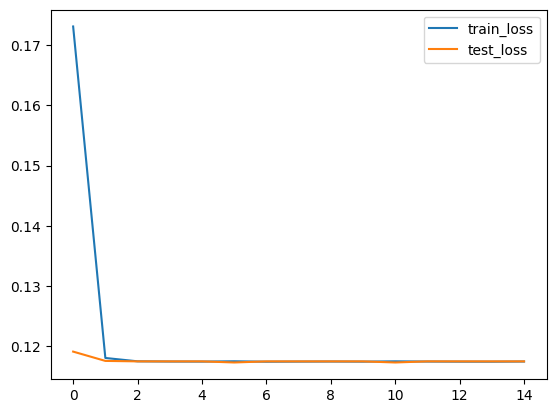

In [35]:
# 学習状況（ロス）の確認
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()

Mymodel(
  (fc1): Sequential(
    (0): Linear(in_features=12, out_features=6, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
  )
)